In [85]:
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
# cancer = "HNSC"
# cancer = "COAD"
cancer = "STAD"
d = pd.read_csv(f"Data/{cancer}/gene_biome_{cancer}.csv", index_col=0)
b = pd.read_csv(f'Data/{cancer}/Microbial/bacteria.sample.relabund.phylum.txt', delimiter = "\t", index_col=0).T
b["tumor"] = b.apply(lambda row: 1 if re.search(r"[0]..$",row.name) else 0, axis=1)

In [86]:
# Visualize data with PCA, making sure it's standardized

from sklearn.decomposition import PCA

def splitData(d, target):
    y = d[target]
    x = d.drop([target], axis=1)
    return x, y

def getPCA(x):
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(x)
    pc_df = pd.DataFrame(data = pcs, columns = ['principal component 1', 'principal component 2'])
    return pc_df

def plotScatter(X, Y, titles=["PCA" for x in range(len(X))], filename=""):
    fig = plt.figure(figsize = (8,8))
    
    for i in range(0, len(X)):
        ax = fig.add_subplot(3,3,(i+1)) 
        ax.set_xlabel('PC 1', fontsize = 15)
        ax.set_ylabel('PC 2', fontsize = 15)
        ax.set_title(titles[i], fontsize = 20)
        targets = ['tumor']
        colors = ['g', 'r']
        ax.scatter(X[i].iloc[:, 0].values, X[i].iloc[:, 1].values, c=Y[i].values, cmap=matplotlib.colors.ListedColormap(colors))
        ax.legend(targets)
        ax.grid()
    plt.tight_layout()
    if filename:
        plt.savefig(filename, transparent=False, facecolor="white")

x, y = splitData(d, "tumor")
mb_all_x, mb_all_y = splitData(b, "tumor")
d_ge = x.drop(x.columns[range(0,11)], axis=1)
d_mb = x.iloc[:, range(0,11)]
print(d_ge.columns)
print(d_mb.columns)
d_mb.head(1)
b.head(1)


Index(['RPS4Y1', 'XIST', 'KRT5', 'AGR2', 'CEACAM5', 'KRT6A', 'KRT14',
       'CEACAM6', 'DDX3Y', 'KDM5D',
       ...
       'FAM129A', 'C8orf48', 'CDK5R1', 'FAM81A', 'C13orf18', 'GDPD3', 'SMAGP',
       'C2orf85', 'POU5F1B', 'CHST2'],
      dtype='object', length=5000)
Index(['Bacteroidetes', 'Proteobacteria', 'Firmicutes', 'Fusobacteria',
       'Verrucomicrobia', 'Chloroflexi', 'Thermotogae', 'Actinobacteria',
       'Spirochaetes', 'Synergistetes', 'Tenericutes'],
      dtype='object')


name,Bacteroidetes,Proteobacteria,Firmicutes,Fusobacteria,Verrucomicrobia,Chloroflexi,Thermotogae,Actinobacteria,Spirochaetes,Synergistetes,Tenericutes,tumor
TCGA-CD-5798-01A,0.199413,0.0,0.800587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [87]:
pc_df = getPCA(d_ge)
pc_df_mb = getPCA(d_mb)
pc_df_mb_all = getPCA(mb_all_x)


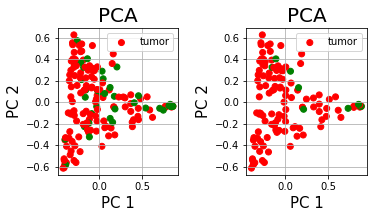

In [88]:
# final_df = pd.concat([pc_df, ])
plotScatter([pc_df_mb_all, pc_df_mb], [mb_all_y, y])

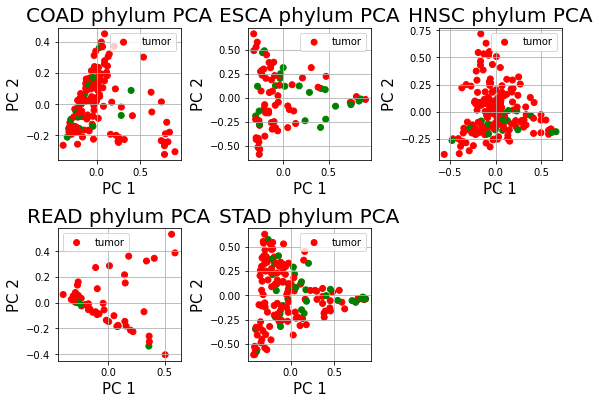

In [89]:
tcma_cancer_type = ["COAD", "ESCA", "HNSC", "READ", "STAD"]
X = []
Y = []
titles = []
for c in tcma_cancer_type:
    b = pd.read_csv(f'Data/{c}/Microbial/bacteria.sample.relabund.phylum.txt', delimiter = "\t", index_col=0).T
    b["tumor"] = b.apply(lambda row: 1 if re.search(r"[0]..$",row.name) else 0, axis=1)
    x, y = splitData(b, "tumor")
    X.append(getPCA(x))
    Y.append(y)
    titles.append(f"{c} phylum PCA")
plotScatter(X, Y, titles, "Visual/TCMA_Phylum_PCA.png")
